<a href="https://colab.research.google.com/github/AyushSrivastava27/brain_tumour_segmentation_2/blob/main/brain_tumour_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-04ecdfb0-16bf-0516-64c7-e3caec0d93c9)


In [ ]:
# importing libraries

import tensorflow as tf
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [ ]:
train_dir = "/content/drive/MyDrive/Brain Tumor"
test_dir = "/content/drive/MyDrive/Brain Tumour Detection/archive/Testing"
train_dir_full = "/content/drive/MyDrive/Brain Tumour Detection/archive/Training"

In [ ]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names)

['notumor' 'glioma' 'pituitary' 'meningioma']


In [ ]:
# Setup data inputs

IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

train_data_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_full,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 1200 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Found 5722 files belonging to 4 classes.


In [ ]:
# Helper Functions

### We are creating a bunch of helpful functions

# Create a function to import an image and resize it to be able to be used with our model

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Make a function to predict on images and plot them
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
# Setting up EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Creating ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Importing the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # removing for EfficientNetB0
], name ="data_augmentation")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model

# Load pre-trained EfficientNetB0 and InceptionV3 models (without top layers)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a shared classification layer
classification_layer = Dense(4, activation='softmax')

# Create input layer
input_layer = Input(shape=(224, 224, 3), name="input_layer")

# Extract features from EfficientNetB0
efficientnet_features = efficientnet_model(input_layer)
efficientnet_features = GlobalAveragePooling2D()(efficientnet_features)

# Extract features from InceptionV3
inception_features = inception_model(input_layer)
inception_features = GlobalAveragePooling2D()(inception_features)

# Concatenate the features
combined_features = Concatenate()([efficientnet_features, inception_features])

# Add the classification layer
output = classification_layer(combined_features)

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=output)

# Compile the model
combined_model.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                      optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                      metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(average='macro')])

# Print model summary
combined_model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_layer[0][0]']         
 )                                                                                                
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_layer[0][0]']         
                                                          4                                       
                             

In [ ]:
# Start to fine-tune
history_1 = combined_model.fit(train_data_full,
                      epochs=100,
                      steps_per_epoch=len(train_data_full),
                      validation_data=test_data,
                      # validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "combined_all_data_fine_tuning"),
                                  model_checkpoint,
                                  early_stopping,
                                  reduce_lr])

Saving TensorBoard log files to: training_logs/combined_all_data_fine_tuning/20240402-170731
Epoch 1/100
179/179 [==============================] - 1625s 8s/step - loss: 0.2252 - accuracy: 0.9229 - precision: 0.9426 - recall: 0.9011 - f1_score: 0.9204 - val_loss: 0.0930 - val_accuracy: 0.9649 - val_precision: 0.9663 - val_recall: 0.9634 - val_f1_score: 0.9624 - lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 110s 606ms/step - loss: 0.0410 - accuracy: 0.9885 - precision: 0.9897 - recall: 0.9879 - f1_score: 0.9881 - val_loss: 0.0607 - val_accuracy: 0.9786 - val_precision: 0.9786 - val_recall: 0.9786 - val_f1_score: 0.9769 - lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 104s 578ms/step - loss: 0.0223 - accuracy: 0.9948 - precision: 0.9948 - recall: 0.9941 - f1_score: 0.9945 - val_loss: 0.0658 - val_accuracy: 0.9794 - val_precision: 0.9794 - val_recall: 0.9794 - val_f1_score: 0.9778 - lr: 1.0000e-04
Epoch 4/100
179/179 [========================

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results = combined_model.evaluate(test_data)
results

41/41 [==============================] - 5s 127ms/step - loss: 0.0209 - accuracy: 0.9947 - precision: 0.9947 - recall: 0.9947 - f1_score: 0.9942


[0.020903998985886574,
 0.9946605563163757,
 0.9946605563163757,
 0.9946605563163757,
 0.9942295551300049]

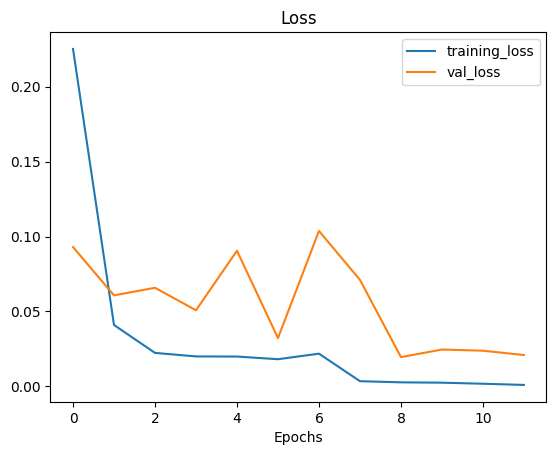

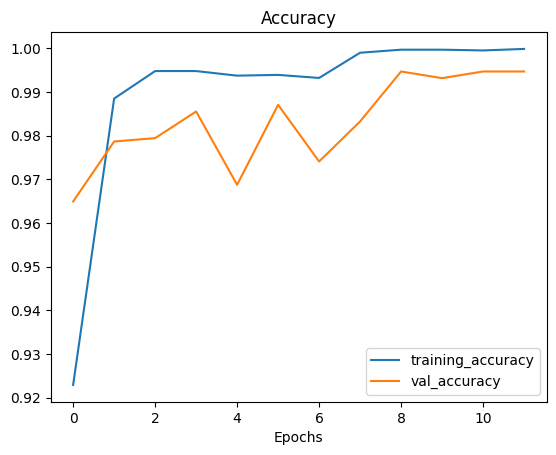

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# Saving our best model

model_path = "drive/My Drive/Data/models/saved_combined_model.h5"
print(f"Saving model to: {model_path}...")
combined_model.save(model_path)

Saving model to: drive/My Drive/Data/models/saved_combined_model.h5...


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model

# Load pre-trained EfficientNetB0 and ResNet50V2 models (without top layers)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50v2_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a shared classification layer for 4 classes
num_classes = 4
classification_layer = Dense(num_classes, activation='softmax')

# Create input layer
input_layer = Input(shape=(224, 224, 3), name="input_layer")

# Extract features from EfficientNetB0
efficientnet_features = efficientnet_model(input_layer)
efficientnet_features = GlobalAveragePooling2D()(efficientnet_features)

# Extract features from ResNet50V2
resnet50v2_features = resnet50v2_model(input_layer)
resnet50v2_features = GlobalAveragePooling2D()(resnet50v2_features)

# Concatenate the features
combined_features = Concatenate()([efficientnet_features, resnet50v2_features])

# Add the classification layer
output = classification_layer(combined_features)

# Create the combined model
combined_model_2 = Model(inputs=input_layer, outputs=output)

# Compile the model
# Compile the model
combined_model_2.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                      optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                      metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(average='macro')])

# Print model summary
combined_model_2.summary()


94668760/94668760 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_layer[0][0]']         
 )                                                                                                
                                                                                                  
 resnet50v2 (Functional)     (None, 7, 7, 2048)           2356480   ['input_layer[0][0]']         
                                                          0                                       
                             

In [ ]:
# Start to fine-tune
history_2 = combined_model_2.fit(train_data_full,
                      epochs=100,
                      steps_per_epoch=len(train_data_full),
                      validation_data=test_data,
                      # validation_steps=int(0.15 * len(test_data)),
                      callbacks=[create_tensorboard_callback("training_logs", "combined_all_data_fine_tuning"),
                                  model_checkpoint,
                                  early_stopping,
                                  reduce_lr])

Saving TensorBoard log files to: training_logs/combined_all_data_fine_tuning/20240404-013523
Epoch 1/100
179/179 [==============================] - 1604s 8s/step - loss: 0.1975 - accuracy: 0.9289 - precision: 0.9462 - recall: 0.9137 - f1_score: 0.9269 - val_loss: 0.0757 - val_accuracy: 0.9710 - val_precision: 0.9710 - val_recall: 0.9695 - val_f1_score: 0.9697 - lr: 1.0000e-04
Epoch 2/100
179/179 [==============================] - 110s 605ms/step - loss: 0.0353 - accuracy: 0.9890 - precision: 0.9898 - recall: 0.9881 - f1_score: 0.9887 - val_loss: 0.0731 - val_accuracy: 0.9748 - val_precision: 0.9748 - val_recall: 0.9725 - val_f1_score: 0.9731 - lr: 1.0000e-04
Epoch 3/100
179/179 [==============================] - 107s 589ms/step - loss: 0.0252 - accuracy: 0.9930 - precision: 0.9932 - recall: 0.9923 - f1_score: 0.9927 - val_loss: 0.1185 - val_accuracy: 0.9641 - val_precision: 0.9676 - val_recall: 0.9573 - val_f1_score: 0.9625 - lr: 1.0000e-04
Epoch 4/100
179/179 [========================

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_2 = combined_model_2.evaluate(test_data)
results_2

41/41 [==============================] - 6s 153ms/step - loss: 0.0525 - accuracy: 0.9886 - precision: 0.9886 - recall: 0.9886 - f1_score: 0.9882


[0.052526142448186874,
 0.9885583519935608,
 0.9885583519935608,
 0.9885583519935608,
 0.9881995916366577]

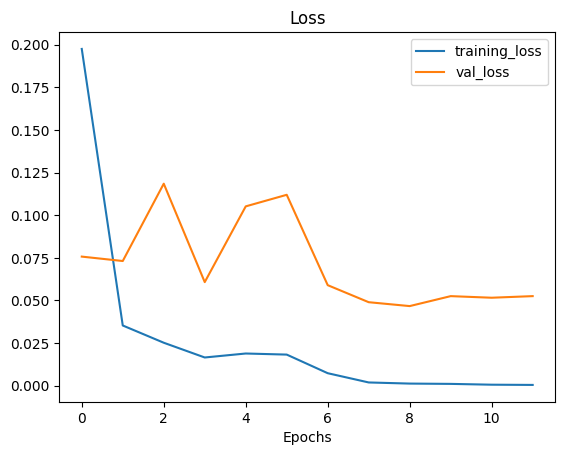

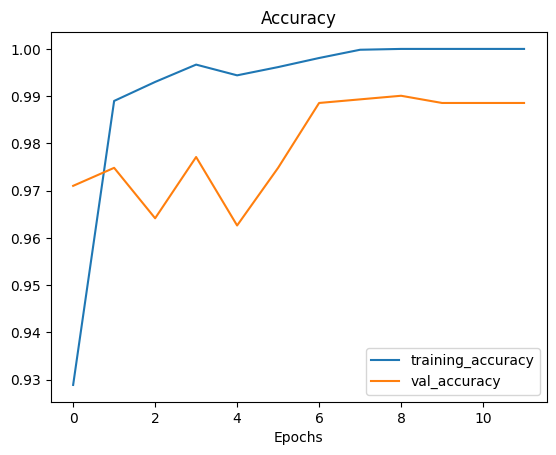

In [ ]:
plot_loss_curves(history_2)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Average
from tensorflow.keras.models import Model

# Load pre-trained EfficientNetB0 and InceptionV3 models (without top layers)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a shared classification layer for 4 classes
num_classes = 4
classification_layer = Dense(num_classes, activation='softmax')

# Create input layer
input_layer = Input(shape=(224, 224, 3), name="input_layer")

# Extract features from EfficientNetB0
efficientnet_features = efficientnet_model(input_layer)
efficientnet_features = GlobalAveragePooling2D()(efficientnet_features)

# Extract features from InceptionV3
inception_features = inception_model(input_layer)
inception_features = GlobalAveragePooling2D()(inception_features)

# # Ensure feature dimensions match
# if efficientnet_features.shape[-1] != inception_features.shape[-1]:
#     raise ValueError("Feature dimensions do not match. Adjust the models or use additional layers.")

# Average the features
averaged_features = Average()([efficientnet_features, inception_features])

# Add an additional dense layer for fine-tuning
combined_features = Dense(256, activation='relu')(averaged_features)

# Add the classification layer
output = classification_layer(combined_features)

# Create the combined model
average_combined_model = Model(inputs=input_layer, outputs=output)

# Compile the model
average_combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
average_combined_model.summary()


87910968/87910968 [==============================] - 3s 0us/step


ValueError: Inputs have incompatible shapes. Received shapes (1280,) and (2048,)

Weighted Averaging

In [ ]:
# Given accuracies
accuracy_efficientnet = 0.9771167039871216
accuracy_resnet50v2 = 0.9153317809104919

# Calculate weights (proportional to accuracy)
total_accuracy = accuracy_efficientnet + accuracy_resnet50v2
weight_efficientnet = accuracy_efficientnet / total_accuracy
weight_resnet50v2 = accuracy_resnet50v2 / total_accuracy

In [ ]:
0.9771167039871216 + 0.9153317809104919

1.8924484848976135

In [ ]:
0.9771167039871216/1.8924484848976135

0.5163240699997106

In [ ]:
0.9153317809104919/1.8924484848976135

0.48367593000028947

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model

# Load pre-trained models (EfficientNetB0, InceptionV3, etc.)
efficientnet_model =   # Load EfficientNet model
inception_model =    # Load Inception model

# Create input layer
input_layer = Input(shape=(224, 224, 3))

# Extract features from each model
efficientnet_features = efficientnet_model(input_layer)
inception_features = inception_model(input_layer)

# Adjust the dimensionality of features
efficientnet_features = Dense(2048)(efficientnet_features)  # Project to match Inception's feature dimension

# Concatenate the features
concatenated_features = Concatenate(axis=-1)([efficientnet_features, inception_features])

# Add classification layer
num_classes = 4
output = Dense(num_classes, activation='softmax')(concatenated_features)

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=output)

# Compile the model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
combined_model.summary()


TypeError: 'float' object is not callable

In [ ]:
efficientnet_features.shape

TensorShape([None, 7, 7, 1280])

In [ ]:
inception_features.shape

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'inception_v3')>